In [ ]:
!pip install pandahouse

In [ ]:
!pip install swifter

In [7]:
import pandas as pd
import pandahouse
import swifter
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from random import sample
import numpy as np
from scipy.stats import ttest_ind

#Задание 3

Задача

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [4]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [26]:
q = """
SELECT  user_id ,
        exp_group,
        sum(action = 'like') likes,
        sum(action = 'view') views,
        likes/views ctr
FROM simulator_20230720.feed_actions
WHERE toDate(time) between '2023-06-30' and '2023-07-06' and exp_group in (0, 1, 2, 3)
GROUP by exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,likes,views,ctr
0,18392,1,7,32,0.218750
1,115383,3,12,44,0.272727
2,131473,2,9,108,0.083333
3,123580,3,2,11,0.181818
4,32420,2,13,44,0.295455


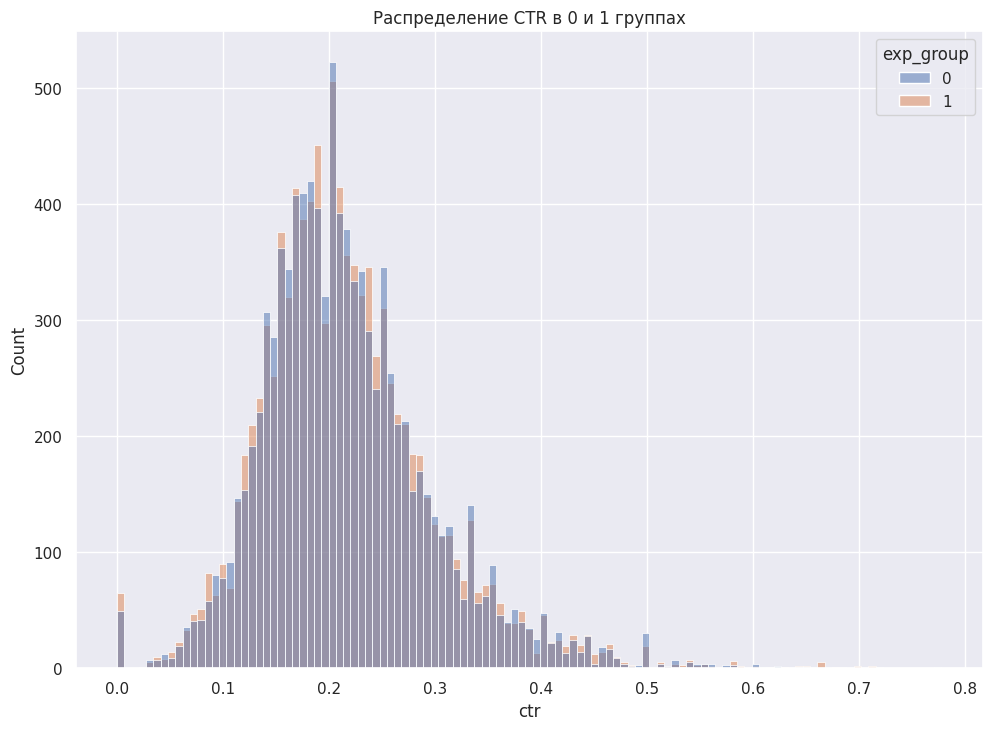

In [27]:
# Рассмотрим ctr в разных группах, для понимания того, что возьмем за контрольную группу
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(data = df[(df['exp_group'] == 0) | (df['exp_group'] == 1)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 0 и 1 группах')
plt.show()

Распределение в группах различаются, рассмотрим в качестве контрольной 0 группу в паре 0-3

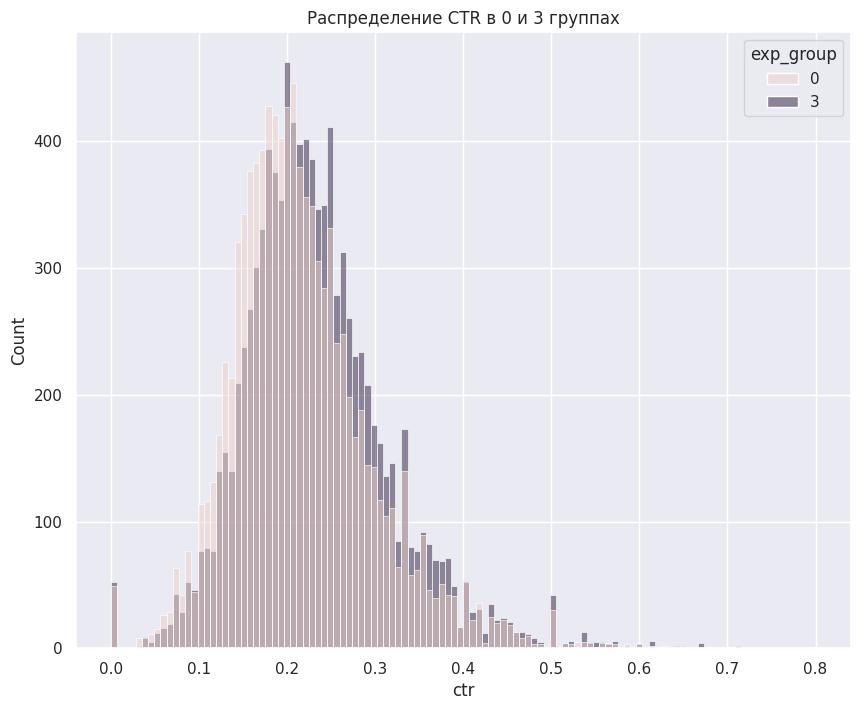

In [28]:
#график построение ctr
sns.set(rc={'figure.figsize':(10,8)})
sns.histplot(data = df[(df['exp_group'] == 0) | (df['exp_group'] == 3)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 0 и 3 группах')
plt.show()

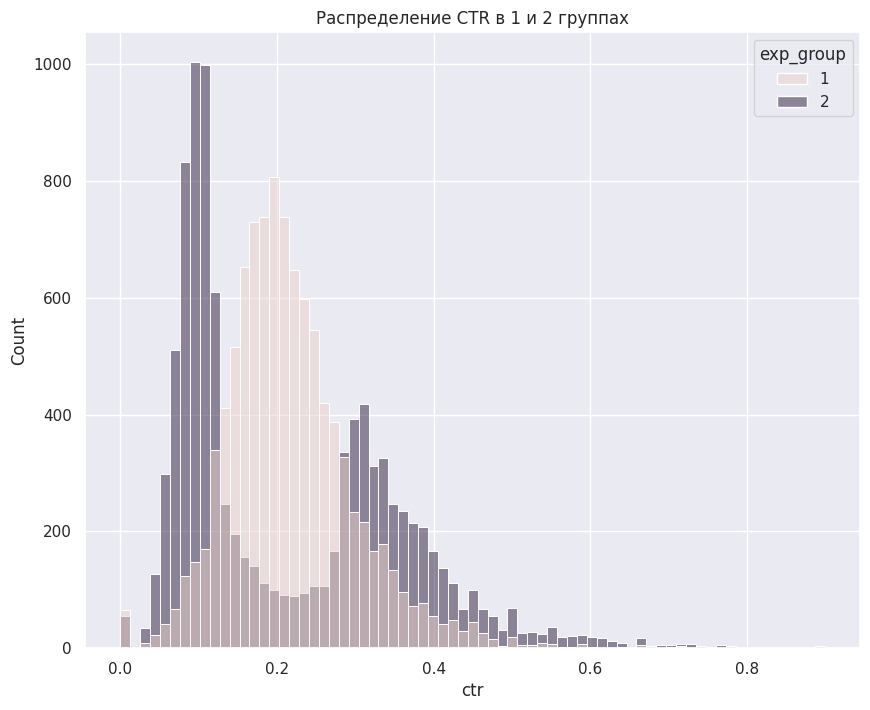

In [29]:
#график построение ctr
sns.set(rc={'figure.figsize':(10,8)})
sns.histplot(data = df[(df['exp_group'] == 1) | (df['exp_group'] == 2)],
            x = 'ctr',
            hue = 'exp_group',
            alpha = 0.5,
            kde = False)
plt.title('Распределение CTR в 1 и 2 группах')
plt.show()

Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)

Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

После чего сравним t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒

In [30]:
# Посчитаем контрольный ctr для всех групп
sum_likes_views = df[['likes', 'views', 'exp_group']].groupby('exp_group').sum(['likes', 'views'])
CTRcontrol = sum_likes_views['likes']/sum_likes_views['views']
CTRcontrol

exp_group
0    0.209838
1    0.209604
2    0.200251
3    0.226207
dtype: float64

In [31]:
# Функция для линеаризации лайков
def linearized_likes(user_likes, user_views, CTRcontrol):
    return  (user_likes - CTRcontrol * user_views)

# Функция для проведения т-теста на линейризованных лайках
def t_test_linearized_likes(df, CTRcontrol, n_control=0, n_test=3):
    group_control = df[df.exp_group == n_control].copy()
    group_control['linearized_ctr'] = group_control.apply(
        lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol[n_control]), axis=1)

    group_test = df[df.exp_group == n_test].copy()
    group_test['linearized_ctr'] = group_test.apply(
        lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol[n_control]), axis=1)

    hist = sns.histplot(group_control.linearized_ctr,
                        kde = False,
                        color = 'y')
    hist = sns.histplot(group_test.linearized_ctr,
                        kde = False,
                        color = 'r',
                        alpha = 0.5)
    hist.legend(['linearized_ctr_control', 'linearized_ctr_test'])
    plt.show()

    t_test = stats.ttest_ind(group_control.linearized_ctr,
                             group_test.linearized_ctr,
                             equal_var=False)
    print(f'\nТ-тест на линеаризованном ctr: \n{t_test}\n')
    if t_test[1] < 0.05:
        print(f'Нулевая гипотеза отклонена средние CTR в {n_control} и {n_test} группах отличаются')
    else:
        print(f'Нулевая гипотеза верна средние CTR в {n_control} и {n_test} группах не отличаются')

    return group_control, group_test

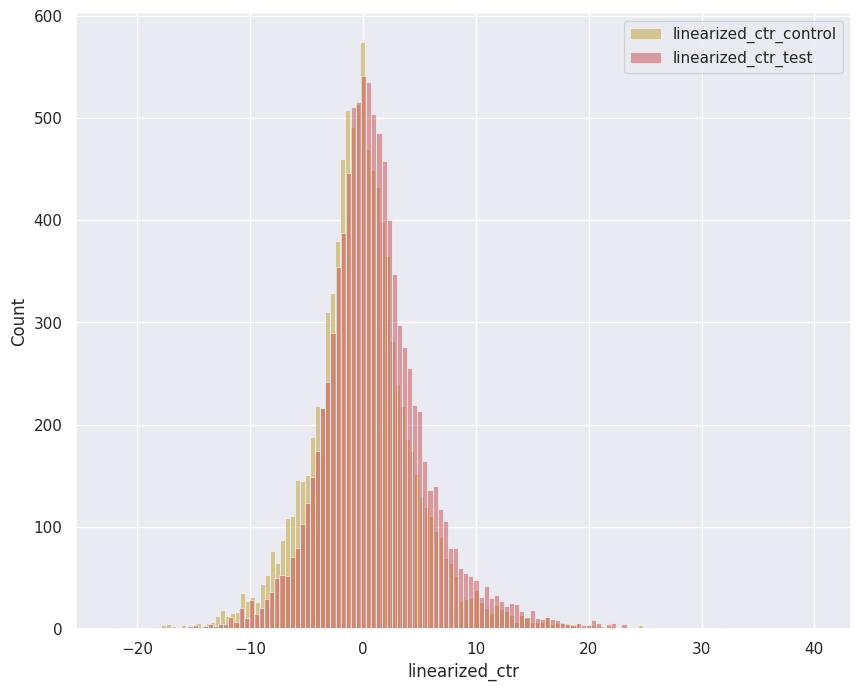


Т-тест на линеаризованном ctr: 
Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

Нулевая гипотеза отклонена средние CTR в 0 и 3 группах отличаются


In [32]:
# Группы 0 и 3
group_control, group_test = t_test_linearized_likes(df, CTRcontrol, n_control=0, n_test=3)

In [34]:
#T-тест
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

Нулевая гипотеза не верна средние CTR в группах 0 и 3 отличаются. p-value на линейризовааном ctr уменьшилось.

# Группы 1 и 2

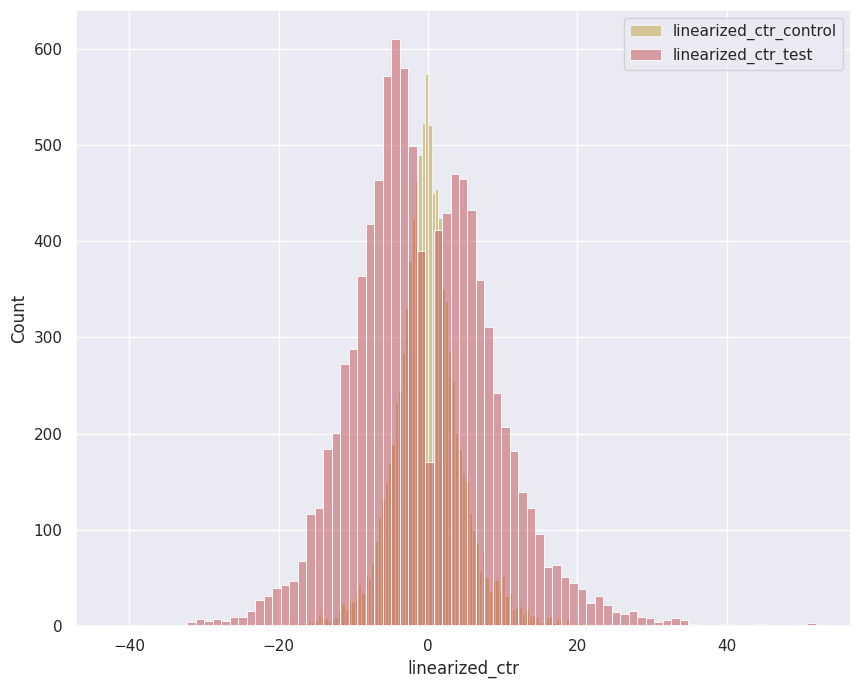


Т-тест на линеаризованном ctr: 
Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

Нулевая гипотеза отклонена средние CTR в 1 и 2 группах отличаются


In [35]:
group_control, group_test = t_test_linearized_likes(df, CTRcontrol, n_control=1, n_test=2)

In [36]:
#T-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

На группах 1 и 2 t-тест на линеаризованном ctr показал различия между группами, и они правда есть. Р-value значительно уменьшилось относительно результата на обычном ctr.
Метрика линеаризованных лайков, несмотря на разное распределение в выборках, хорошо себя показала.